In [1]:
from nnsight.modeling.diffusion import DiffusionModel
import matplotlib.pyplot as plt
from math import ceil, sqrt
import PIL
import torch

/share/u/adam/miniconda3/envs/nns-env3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prompt = "Penguin playing chess at a wooden table in a snowy landscape."

## Stable Diffusion XL

In [3]:
ADD_LAYER_NORM = False
SEED = 432
NUM_INFERENCE_STEPS = 40
STEP_SIZE = 2

In [4]:
model = DiffusionModel(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16",
    dispatch=True
).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.22it/s]


In [5]:
# Defines the hidden states to embed, we skip the last layer because SDXL ignores it
layers = range(0, model.text_encoder_2.config.num_hidden_layers - 1, STEP_SIZE)
images = []

# Create an empty prompt input for the first text encoder
# This will be used to mask out the original text input, allowing us to isolate 
# the effect of injecting hidden states from the second text encoder
mask_input = model.tokenizer(
    '',  # Empty string as we want to mask out the original text
    padding="max_length",
    max_length=model.tokenizer.model_max_length,
    truncation=True,
    return_overflowing_tokens=False,
    return_length=False,
    return_tensors="pt"
).to(model.device)

for layer in layers:
    print(f"Generating Diffusion Lens for skip_layers {model.text_encoder_2.config.num_hidden_layers - layer}")
    with model.generate(
        prompt,
        num_inference_steps=40,
        seed=432
        ):
        
        # Replace the input to the first text encoder with our empty mask
        # This effectively nullifies the contribution of the first text encoder
        model.text_encoder.input = mask_input['input_ids']
        
        if ADD_LAYER_NORM:

            hidden_state = model.text_encoder_2.text_model.encoder.layers[layer].output[0]

            # SDXL grabs the penultimate hidden state from the text encoder
            model.text_encoder_2.text_model.encoder.layers[-2].output[0][:] = model.text_encoder_2.text_model.final_layer_norm(hidden_state)[0][:]
        else:
            # SDXL grabs the penultimate hidden state from the text encoder
            model.text_encoder_2.text_model.encoder.layers[-2].output[0][:] = model.text_encoder_2.text_model.encoder.layers[layer].output[0][:]
        
        # Save the generated image and add it to our collection
        image = model.output.images[0].save()
        images.append(image)

if not isinstance(images[0], PIL.Image.Image):
    images = [image.value for image in images]


Generating Diffusion Lens for skip_layers 32


100%|██████████| 40/40 [00:06<00:00,  6.56it/s]


Generating Diffusion Lens for skip_layers 30


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Generating Diffusion Lens for skip_layers 28


100%|██████████| 40/40 [00:06<00:00,  6.54it/s]


Generating Diffusion Lens for skip_layers 26


100%|██████████| 40/40 [00:06<00:00,  6.45it/s]


Generating Diffusion Lens for skip_layers 24


100%|██████████| 40/40 [00:06<00:00,  6.37it/s]


Generating Diffusion Lens for skip_layers 22


100%|██████████| 40/40 [00:06<00:00,  6.28it/s]


Generating Diffusion Lens for skip_layers 20


100%|██████████| 40/40 [00:06<00:00,  6.21it/s]


Generating Diffusion Lens for skip_layers 18


100%|██████████| 40/40 [00:06<00:00,  6.17it/s]


Generating Diffusion Lens for skip_layers 16


100%|██████████| 40/40 [00:06<00:00,  6.12it/s]


Generating Diffusion Lens for skip_layers 14


100%|██████████| 40/40 [00:06<00:00,  6.08it/s]


Generating Diffusion Lens for skip_layers 12


100%|██████████| 40/40 [00:06<00:00,  6.04it/s]


Generating Diffusion Lens for skip_layers 10


100%|██████████| 40/40 [00:06<00:00,  6.01it/s]


Generating Diffusion Lens for skip_layers 8


100%|██████████| 40/40 [00:06<00:00,  5.89it/s]


Generating Diffusion Lens for skip_layers 6


100%|██████████| 40/40 [00:06<00:00,  5.95it/s]


Generating Diffusion Lens for skip_layers 4


100%|██████████| 40/40 [00:06<00:00,  5.94it/s]


Generating Diffusion Lens for skip_layers 2


100%|██████████| 40/40 [00:06<00:00,  5.91it/s]


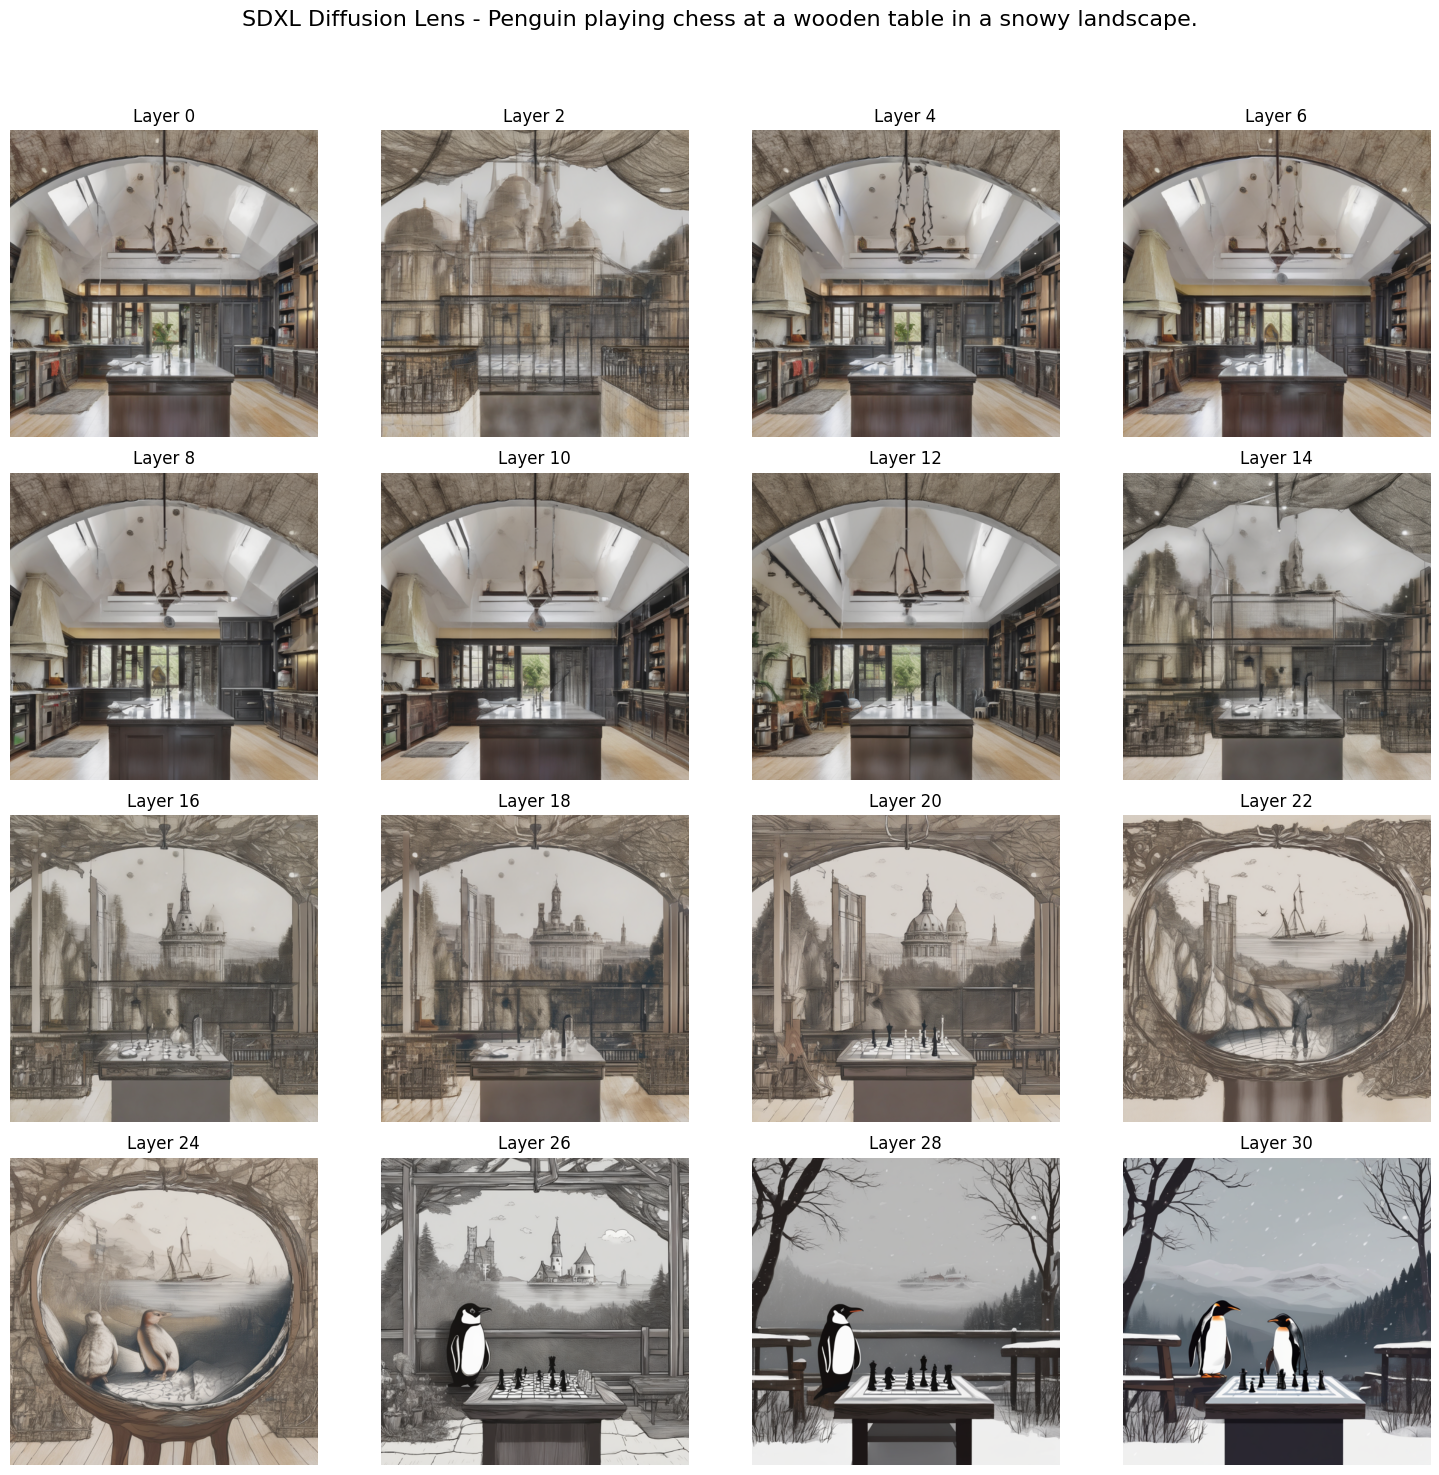

In [6]:
# Calculate grid dimensions
num_images = len(images)
grid_size = ceil(sqrt(num_images))
fig, axes = plt.subplots(ceil(num_images / grid_size), grid_size, figsize=(15, 15))
axes = axes.flatten()

# Add a main title to the figure
fig.suptitle(f"SDXL Diffusion Lens - {prompt}", fontsize=16)

# Display images in a grid
for i, (layer, image) in enumerate(zip(layers, images)):
    if i < len(axes):
        axes[i].imshow(image.resize((512, 512)))
        axes[i].set_title(f"Layer {layer}")
        axes[i].axis('off')

# Hide any unused subplots
for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## FLUX SCHNELL

In [3]:
SEED = 17
NUM_INFERENCE_STEPS = 1
STEP_SIZE = 2
GUIDANCE_SCALE = 0.0
HEIGHT = 512
WIDTH = 512

In [4]:
model = DiffusionModel(
    "black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, dispatch=True
).to('cuda')

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.64it/s]


In [5]:
layers = range(0, model.text_encoder_2.config.num_hidden_layers - 1, STEP_SIZE)
images = []

mask_input = model.tokenizer(
    '',
    padding="max_length",
    max_length=model.tokenizer.model_max_length,
    truncation=True,
    return_overflowing_tokens=False,
    return_length=False,
    return_tensors="pt"
).to(model.device)

for layer in layers:
    print(f"Generating Diffusion Lens for skip_layers {model.text_encoder_2.config.num_hidden_layers - layer}")
    with torch.no_grad():
        with model.generate(
            prompt,
            guidance_scale=0.0,
            height=512,
            width=512,
            num_inference_steps=1,
            seed=17
        ):
            model.text_encoder.input = mask_input['input_ids']
            
            model.text_encoder_2.encoder.final_layer_norm.input = model.text_encoder_2.encoder.block[layer].output[0]
            
            image = model.output.images[0].save()
            images.append(image)

if not isinstance(images[0], PIL.Image.Image):
    images = [image.value for image in images]

Generating Diffusion Lens for skip_layers 24


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Generating Diffusion Lens for skip_layers 22


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Generating Diffusion Lens for skip_layers 20


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Generating Diffusion Lens for skip_layers 18


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Generating Diffusion Lens for skip_layers 16


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Generating Diffusion Lens for skip_layers 14


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Generating Diffusion Lens for skip_layers 12


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Generating Diffusion Lens for skip_layers 10


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Generating Diffusion Lens for skip_layers 8


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Generating Diffusion Lens for skip_layers 6


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Generating Diffusion Lens for skip_layers 4


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Generating Diffusion Lens for skip_layers 2


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


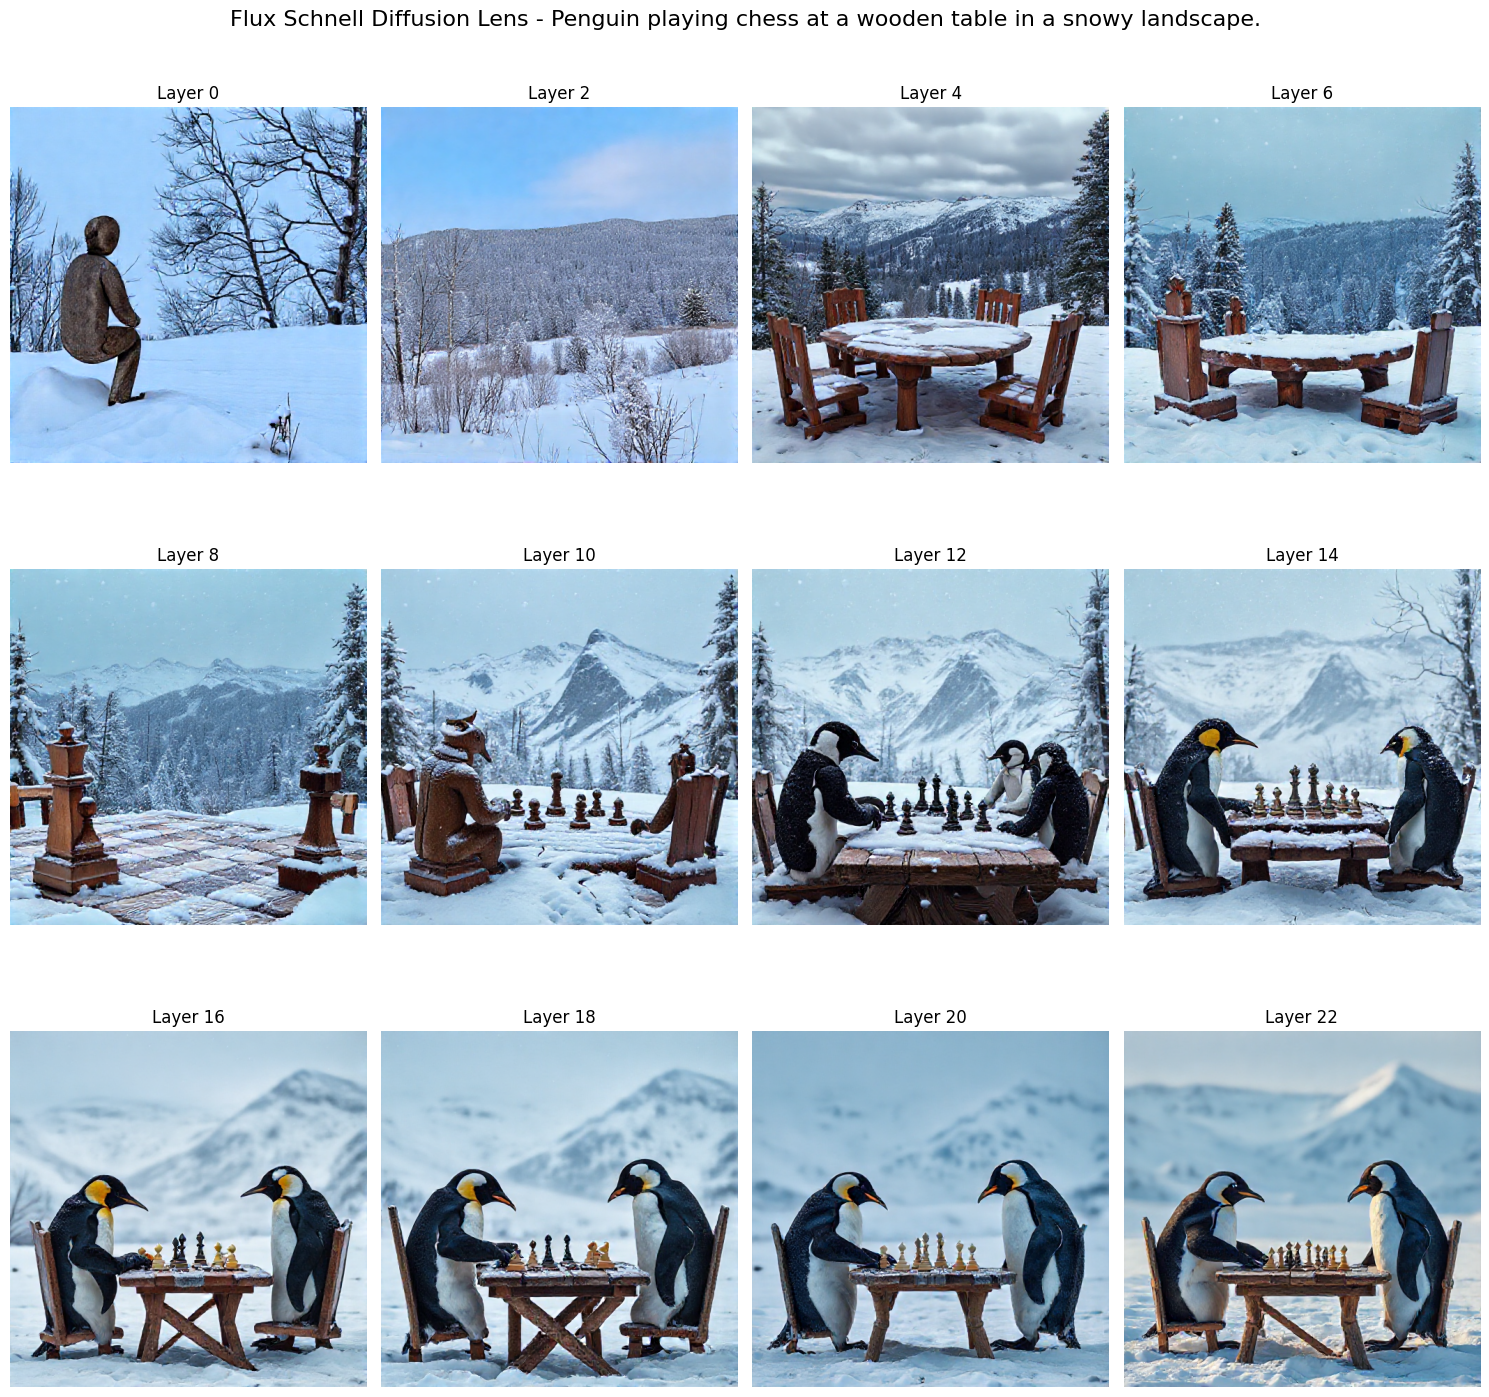

In [6]:
# Calculate grid dimensions
num_images = len(images)
grid_size = ceil(sqrt(num_images))
fig, axes = plt.subplots(ceil(num_images / grid_size), grid_size, figsize=(15, 15))
axes = axes.flatten()

# Add a main title to the figure
fig.suptitle(f"Flux Schnell Diffusion Lens - {prompt}", fontsize=16)

# Display images in a grid
for i, (layer, image) in enumerate(zip(layers, images)):
    if i < len(axes):
        axes[i].imshow(image)
        axes[i].set_title(f"Layer {layer}")
        axes[i].axis('off')

# Hide any unused subplots
for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
# Adjust layout to make room for the title
# plt.subplots_adjust(top=0.9)
plt.show()